In [5]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [8]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [9]:
df = load_csv()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

In [5]:
# Number of instances by class
df.loc[:,'Family'].value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [6]:
df.loc[:,'Genus'].value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [7]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

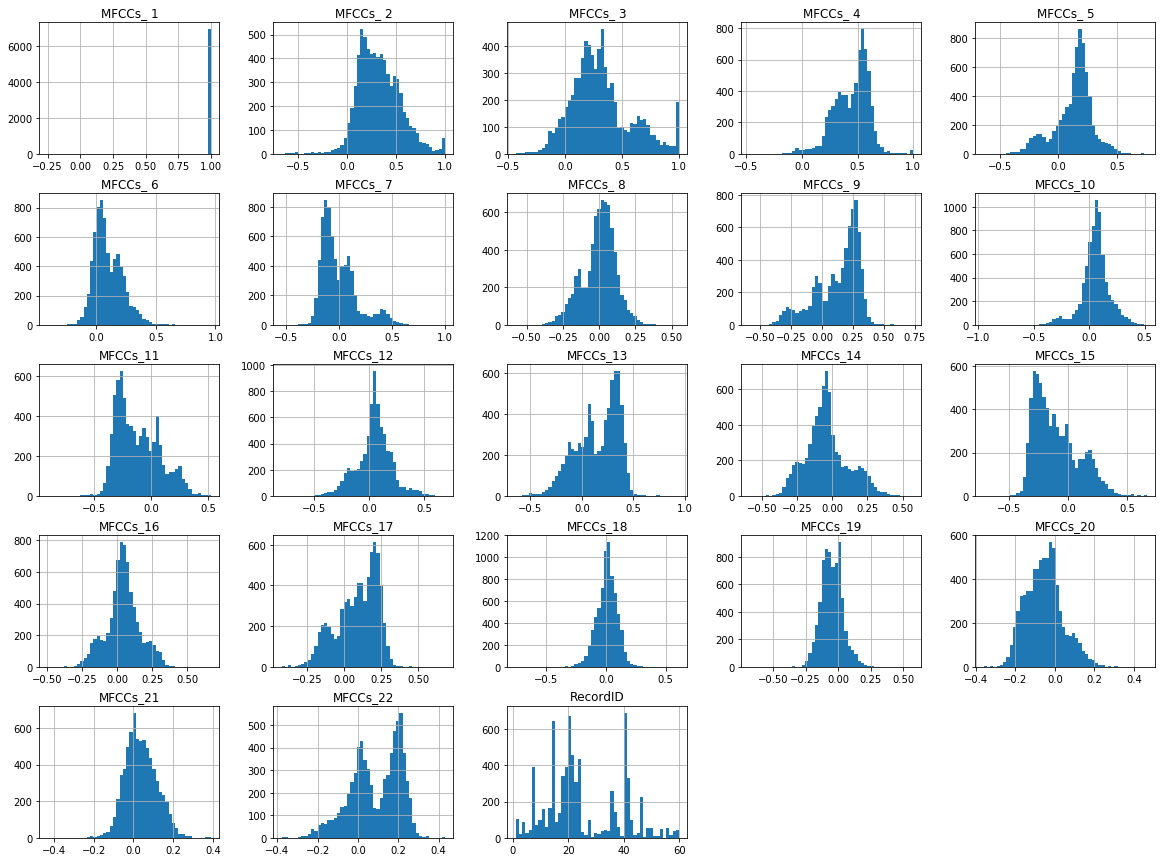

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
# Right now only choosing species
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Species']

In [50]:
from imblearn.under_sampling import RandomUnderSampler

dict = {
    'AdenomeraHylaedactylus': 1121
}

rus = RandomUnderSampler(ratio=dict)
X_resampled, Y_resampled = rus.fit_sample(X, Y)

print(str(X_resampled.size))
print(str(Y_resampled.size))

print(str(X.size))
print(str(Y.size))

print(pd.value_counts(Y_resampled))

106436
4838
158290
7195
AdenomeraHylaedactylus    1121
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
dtype: int64


In [16]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def createOneHotEncoded(arg):
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arg)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

In [17]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        #val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        #val_targ = self.validation_data[1]
        val_targ = np.argmax(self.validation_data[1], axis=1)
        
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        # print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

Using TensorFlow backend.


In [18]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def createModel():
    model = Sequential()

    model.add(Dense(units=22, activation='relu', input_dim=22))
    model.add(Dense(units=32, activation='relu'))
    
    model.add(Dense(units=10, activation='softmax')) #10 species
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    
    return model

In [51]:
from sklearn.metrics import classification_report

N_EPOCHS = 100
BATCH_SIZE = 32

metrics = []

def trainAndTestModel(model, x_train, y_train, x_val, y_val):
    
    # Create new callback class
    metrics.append(Metrics())
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, callbacks=[metrics[-1]])
    
    pred = model.predict(x_val, batch_size=32, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    
    report = classification_report(argmax(y_val, axis=1), y_pred)
    
    #TODO: see if we need this
    #report = pandas_classification_report(np.argmax(y_val, axis=1), y_pred)
    
    mFeature = metricsByFeature(argmax(y_val, axis=1), y_pred)
    featuresMetrics.append(mFeature)
    
    print(report)
    
    return history 

In [48]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

np.random.seed(0)

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

def metricsByFeature(y_true, y_pred):
        metricsSummary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
        
        finalMetrics = {
            'precision': metricsSummary[0],
            'recall': metricsSummary[1],
            'f1-score': metricsSummary[2],
            'support': metricsSummary[3]
        }
        
        return finalMetrics


In [54]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

historyList = []
featuresMetrics = []
metrics = []
#reportList = []

for index, (train_indices, val_indices) in enumerate(skf.split(X_resampled, Y_resampled)):
    
    # Generate batches from indices
    xtrain, xval = X_resampled[train_indices], X_resampled[val_indices]
    ytrain, yval = createOneHotEncoded(Y_resampled[train_indices]), createOneHotEncoded(Y_resampled[val_indices])
    
    # Clear model, and create it
    model = None
    model = createModel()
    
    history = trainAndTestModel(model, xtrain, ytrain, xval, yval)
    
    historyList.append(history)
    

Train on 3866 samples, validate on 972 samples
Epoch 1/100
3866/3866 [==============================] - 1s 310us/step - loss: 2.2231 - acc: 0.1829 - val_loss: 2.1276 - val_acc: 0.2294
Epoch 2/100
1920/3866 [=============>................] - ETA: 0s - loss: 2.0940 - acc: 0.2396

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3866/3866 [==============================] - 0s 105us/step - loss: 2.0551 - acc: 0.2799 - val_loss: 1.9756 - val_acc: 0.4239
Epoch 3/100
3866/3866 [==============================] - 0s 95us/step - loss: 1.9184 - acc: 0.4317 - val_loss: 1.8565 - val_acc: 0.4527
Epoch 4/100
3866/3866 [==============================] - 0s 96us/step - loss: 1.8033 - acc: 0.4338 - val_loss: 1.7412 - val_acc: 0.4733
Epoch 5/100
3866/3866 [==============================] - 0s 106us/step - loss: 1.6823 - acc: 0.4747 - val_loss: 1.6172 - val_acc: 0.5165
Epoch 6/100
3866/3866 [==============================] - 0s 85us/step - loss: 1.5565 - acc: 0.5248 - val_loss: 1.4938 - val_acc: 0.6070
Epoch 7/100
3866/3866 [==============================] - 0s 84us/step - loss: 1.4358 - acc: 0.6270 - val_loss: 1.3800 - val_acc: 0.6471
Epoch 8/100
3866/3866 [==============================] - 0s 93us/step - loss: 1.3266 - acc: 0.6516 - val_loss: 1.2784 - val_acc: 0.6574
Epoch 9/100
3866/3866 [==============================] - 1

Epoch 62/100
3866/3866 [==============================] - 0s 113us/step - loss: 0.3101 - acc: 0.9203 - val_loss: 0.3089 - val_acc: 0.9228
Epoch 63/100
3866/3866 [==============================] - 0s 98us/step - loss: 0.3078 - acc: 0.9221 - val_loss: 0.3064 - val_acc: 0.9239
Epoch 64/100
3866/3866 [==============================] - 0s 104us/step - loss: 0.3053 - acc: 0.9229 - val_loss: 0.3042 - val_acc: 0.9218
Epoch 65/100
3866/3866 [==============================] - 0s 60us/step - loss: 0.3024 - acc: 0.9237 - val_loss: 0.3019 - val_acc: 0.9228
Epoch 66/100
3866/3866 [==============================] - 0s 69us/step - loss: 0.3001 - acc: 0.9237 - val_loss: 0.2986 - val_acc: 0.9239
Epoch 67/100
3866/3866 [==============================] - 0s 128us/step - loss: 0.2966 - acc: 0.9273 - val_loss: 0.2970 - val_acc: 0.9218
Epoch 68/100
3866/3866 [==============================] - 0s 128us/step - loss: 0.2944 - acc: 0.9263 - val_loss: 0.2946 - val_acc: 0.9239
Epoch 69/100
3866/3866 [=============

Epoch 17/100
3868/3868 [==============================] - 0s 68us/step - loss: 0.9382 - acc: 0.7381 - val_loss: 0.9177 - val_acc: 0.7443
Epoch 18/100
3868/3868 [==============================] - 0s 82us/step - loss: 0.8833 - acc: 0.7451 - val_loss: 0.8666 - val_acc: 0.7454
Epoch 19/100
3868/3868 [==============================] - 0s 79us/step - loss: 0.8333 - acc: 0.7544 - val_loss: 0.8183 - val_acc: 0.7608
Epoch 20/100
3868/3868 [==============================] - 0s 72us/step - loss: 0.7886 - acc: 0.7642 - val_loss: 0.7768 - val_acc: 0.7701
Epoch 21/100
3868/3868 [==============================] - 0s 73us/step - loss: 0.7487 - acc: 0.7805 - val_loss: 0.7398 - val_acc: 0.7866
Epoch 22/100
3868/3868 [==============================] - 0s 111us/step - loss: 0.7136 - acc: 0.7924 - val_loss: 0.7064 - val_acc: 0.7969
Epoch 23/100
3868/3868 [==============================] - 0s 74us/step - loss: 0.6820 - acc: 0.8064 - val_loss: 0.6762 - val_acc: 0.8072
Epoch 24/100
3868/3868 [================

Epoch 77/100
3868/3868 [==============================] - 0s 73us/step - loss: 0.2689 - acc: 0.9336 - val_loss: 0.2922 - val_acc: 0.9330
Epoch 78/100
3868/3868 [==============================] - 0s 71us/step - loss: 0.2679 - acc: 0.9361 - val_loss: 0.2931 - val_acc: 0.9289
Epoch 79/100
3868/3868 [==============================] - 0s 82us/step - loss: 0.2662 - acc: 0.9361 - val_loss: 0.2910 - val_acc: 0.9289
Epoch 80/100
3868/3868 [==============================] - 0s 99us/step - loss: 0.2643 - acc: 0.9377 - val_loss: 0.2915 - val_acc: 0.9278
Epoch 81/100
3868/3868 [==============================] - 0s 74us/step - loss: 0.2624 - acc: 0.9380 - val_loss: 0.2903 - val_acc: 0.9289
Epoch 82/100
3868/3868 [==============================] - 0s 61us/step - loss: 0.2607 - acc: 0.9372 - val_loss: 0.2886 - val_acc: 0.9289
Epoch 83/100
3868/3868 [==============================] - 0s 69us/step - loss: 0.2594 - acc: 0.9374 - val_loss: 0.2875 - val_acc: 0.9289
Epoch 84/100
3868/3868 [=================

Epoch 32/100
3871/3871 [==============================] - 0s 105us/step - loss: 0.5044 - acc: 0.8447 - val_loss: 0.4927 - val_acc: 0.8511
Epoch 33/100
3871/3871 [==============================] - 0s 105us/step - loss: 0.4933 - acc: 0.8481 - val_loss: 0.4823 - val_acc: 0.8552
Epoch 34/100
3871/3871 [==============================] - 0s 110us/step - loss: 0.4830 - acc: 0.8522 - val_loss: 0.4716 - val_acc: 0.8594
Epoch 35/100
3871/3871 [==============================] - 0s 99us/step - loss: 0.4728 - acc: 0.8571 - val_loss: 0.4618 - val_acc: 0.8614
Epoch 36/100
3871/3871 [==============================] - 0s 104us/step - loss: 0.4636 - acc: 0.8592 - val_loss: 0.4552 - val_acc: 0.8645
Epoch 37/100
3871/3871 [==============================] - 0s 105us/step - loss: 0.4555 - acc: 0.8654 - val_loss: 0.4444 - val_acc: 0.8811
Epoch 38/100
3871/3871 [==============================] - 0s 96us/step - loss: 0.4469 - acc: 0.8685 - val_loss: 0.4372 - val_acc: 0.8811
Epoch 39/100
3871/3871 [============

Epoch 92/100
3871/3871 [==============================] - 0s 64us/step - loss: 0.2657 - acc: 0.9217 - val_loss: 0.2694 - val_acc: 0.9255
Epoch 93/100
3871/3871 [==============================] - 0s 65us/step - loss: 0.2639 - acc: 0.9228 - val_loss: 0.2666 - val_acc: 0.9255
Epoch 94/100
3871/3871 [==============================] - 0s 62us/step - loss: 0.2628 - acc: 0.9222 - val_loss: 0.2666 - val_acc: 0.9286
Epoch 95/100
3871/3871 [==============================] - 0s 65us/step - loss: 0.2605 - acc: 0.9248 - val_loss: 0.2646 - val_acc: 0.9276
Epoch 96/100
3871/3871 [==============================] - 0s 64us/step - loss: 0.2595 - acc: 0.9253 - val_loss: 0.2632 - val_acc: 0.9276
Epoch 97/100
3871/3871 [==============================] - 0s 69us/step - loss: 0.2580 - acc: 0.9215 - val_loss: 0.2616 - val_acc: 0.9266
Epoch 98/100
3871/3871 [==============================] - 0s 95us/step - loss: 0.2556 - acc: 0.9243 - val_loss: 0.2615 - val_acc: 0.9235
Epoch 99/100
3871/3871 [=================

Epoch 47/100
3873/3873 [==============================] - 0s 66us/step - loss: 0.3721 - acc: 0.8965 - val_loss: 0.3969 - val_acc: 0.8850
Epoch 48/100
3873/3873 [==============================] - 0s 73us/step - loss: 0.3660 - acc: 0.8962 - val_loss: 0.3929 - val_acc: 0.8860
Epoch 49/100
3873/3873 [==============================] - 0s 70us/step - loss: 0.3610 - acc: 0.8988 - val_loss: 0.3865 - val_acc: 0.8870
Epoch 50/100
3873/3873 [==============================] - 0s 67us/step - loss: 0.3556 - acc: 0.9024 - val_loss: 0.3841 - val_acc: 0.8902
Epoch 51/100
3873/3873 [==============================] - 0s 77us/step - loss: 0.3503 - acc: 0.9042 - val_loss: 0.3830 - val_acc: 0.8881
Epoch 52/100
3873/3873 [==============================] - 0s 67us/step - loss: 0.3459 - acc: 0.9058 - val_loss: 0.3733 - val_acc: 0.8943
Epoch 53/100
3873/3873 [==============================] - 0s 89us/step - loss: 0.3413 - acc: 0.9096 - val_loss: 0.3724 - val_acc: 0.8943
Epoch 54/100
3873/3873 [=================

Epoch 2/100
3874/3874 [==============================] - 0s 64us/step - loss: 1.9523 - acc: 0.2318 - val_loss: 1.9066 - val_acc: 0.2459
Epoch 3/100
3874/3874 [==============================] - 0s 78us/step - loss: 1.8714 - acc: 0.2463 - val_loss: 1.8330 - val_acc: 0.2842
Epoch 4/100
3874/3874 [==============================] - 0s 59us/step - loss: 1.7944 - acc: 0.2909 - val_loss: 1.7513 - val_acc: 0.4077
Epoch 5/100
3874/3874 [==============================] - 0s 59us/step - loss: 1.7055 - acc: 0.4427 - val_loss: 1.6598 - val_acc: 0.4761
Epoch 6/100
3874/3874 [==============================] - 0s 58us/step - loss: 1.6156 - acc: 0.5418 - val_loss: 1.5702 - val_acc: 0.5571
Epoch 7/100
3874/3874 [==============================] - 0s 71us/step - loss: 1.5281 - acc: 0.5754 - val_loss: 1.4855 - val_acc: 0.5685
Epoch 8/100
3874/3874 [==============================] - 1s 136us/step - loss: 1.4455 - acc: 0.5839 - val_loss: 1.4054 - val_acc: 0.5840
Epoch 9/100
3874/3874 [========================

Epoch 62/100
3874/3874 [==============================] - 0s 80us/step - loss: 0.3105 - acc: 0.9254 - val_loss: 0.3332 - val_acc: 0.9139
Epoch 63/100
3874/3874 [==============================] - 0s 66us/step - loss: 0.3076 - acc: 0.9259 - val_loss: 0.3318 - val_acc: 0.9129
Epoch 64/100
3874/3874 [==============================] - 0s 72us/step - loss: 0.3046 - acc: 0.9246 - val_loss: 0.3287 - val_acc: 0.9149
Epoch 65/100
3874/3874 [==============================] - 0s 68us/step - loss: 0.3020 - acc: 0.9269 - val_loss: 0.3264 - val_acc: 0.9160
Epoch 66/100
3874/3874 [==============================] - 0s 68us/step - loss: 0.2995 - acc: 0.9290 - val_loss: 0.3246 - val_acc: 0.9149
Epoch 67/100
3874/3874 [==============================] - 0s 70us/step - loss: 0.2972 - acc: 0.9262 - val_loss: 0.3313 - val_acc: 0.9180
Epoch 68/100
3874/3874 [==============================] - 0s 69us/step - loss: 0.2954 - acc: 0.9267 - val_loss: 0.3203 - val_acc: 0.9160
Epoch 69/100
3874/3874 [=================

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotAccuracy(results):
    plt.figure(0)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['acc']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['acc'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.2, 1.0, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Num of Epochs")
    
    plt.show()
    
def plotLoss(results):
    plt.figure(1)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['loss']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['loss'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0, 2.3, 0.1))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Num of Epochs")
    
    plt.show()
    

plotAccuracy(historyList)
plotLoss(historyList)


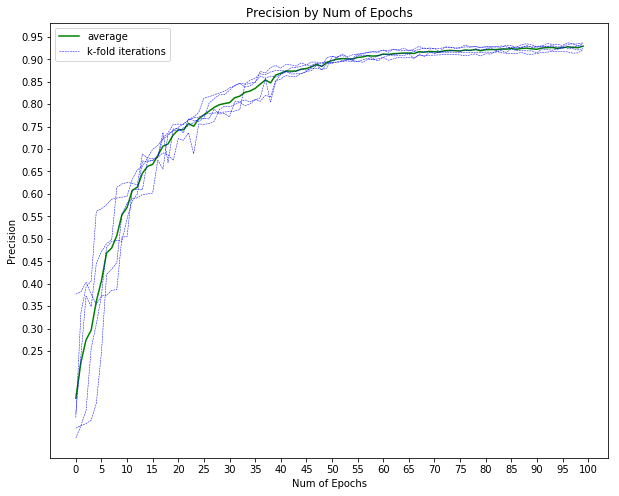

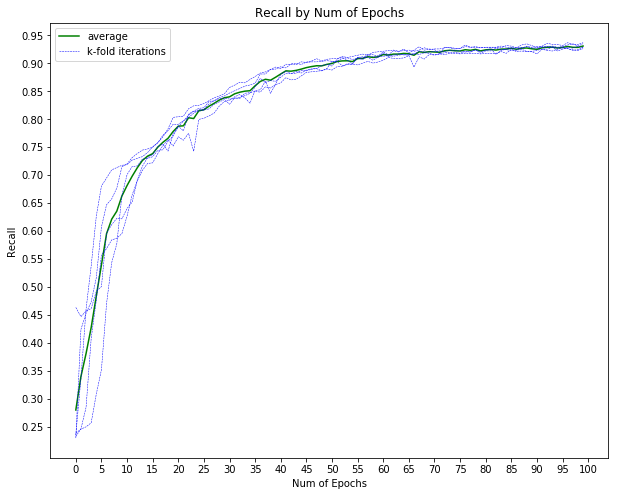

In [108]:
def plotPrecision(metrics):
    plt.figure(2)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_precisions
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_precisions, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
       
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Precision")
    plt.title("Precision by Num of Epochs")
    
    plt.show()
        
def plotRecall(metrics):
    plt.figure(3)
        
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_recalls
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_recalls, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
    
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Recall")
    plt.title("Recall by Num of Epochs")
    plt.show()
    
plotPrecision(metrics)
plotRecall(metrics)
    
    

<Figure size 720x576 with 0 Axes>

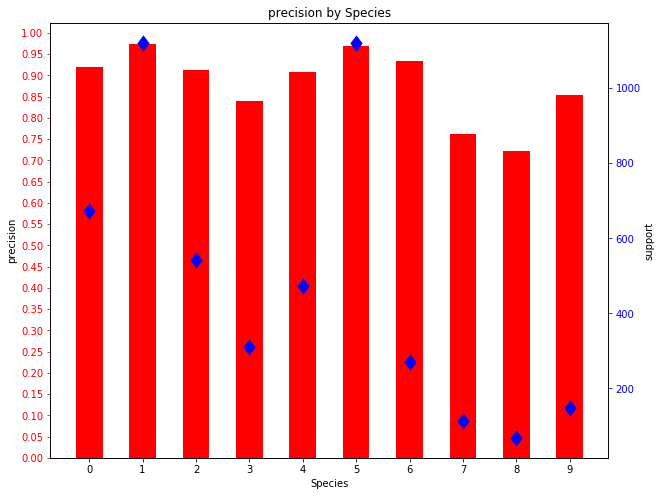

<Figure size 720x576 with 0 Axes>

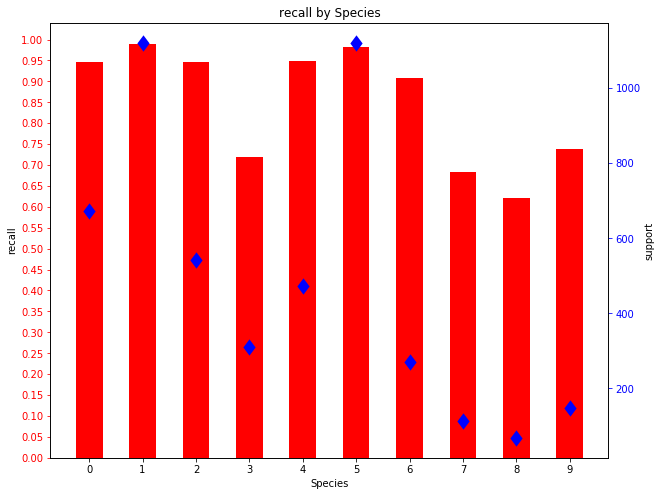

In [109]:
def plotMetricByFeature(values, metric):
    plt.figure(4)
    
    fig, ax1 = plt.subplots()
    
    precisionSum = np.zeros(10) #Number of features (species)
    supportSum = np.zeros(10) #Number of features (species)
    
    for val in values:
        precisionSum += val[metric]
        supportSum += val['support']
        
    avgPrecision = precisionSum / 5 # Number of folds
    
    plt.xticks(np.arange(0, 10, 1.0))
    plt.yticks(np.arange(0, 1.1, 0.05))
    
    ax1.set_xlabel("Species")
    ax1.set_ylabel(metric)
    ax1.tick_params('y', colors='r')
    
    plt.title(metric + " by Species") 
    
    for index, val in enumerate(avgPrecision):
        ax1.bar(index, val, width=0.5, color='red')
        
    ax2 = ax1.twinx()
    for index, val in enumerate(supportSum):
        ax2.plot(index, val, 'db', mew='5')
        
    ax2.set_ylabel('support')
    ax2.tick_params('y', colors='b')
        
    plt.show()
    
plotMetricByFeature(featuresMetrics, 'precision')
plotMetricByFeature(featuresMetrics, 'recall')

    
